# **Sequência**


*   Criar os diretórios:

```
1.   ./originals
2.   ./reference
3.   ./aligned
4.   ./keypoints
5.   ./grayscale
6.   ./grayscale_masks
7.   ./colours_masks
8.   ./plots
```


*   Carregar imagem de referência em `./reference` e usar o nome `reference.jpg`, e carregar imagens de comparação em `./originals`;
*  As imagens alinhadas ficarão salvas em `./aligned`;
*   Os pontos-chave da imagem de referência e imagens de comparação ficarão salvos em `./reference` e `./keypoints` respectivamente;
*   O cálculo do SSIM entre as imagens de comparação e a imagem de referência só será impresso na tela;
*   A aplicação de contraste cinza na imagem de referência e imagens de comparação ficarão salvos em `./reference` e `./grayscale` respectivamente;
*   As diferenças entre as imagens de comparação em cinza em relação a imagem de referência em cinza, usando segmentação com subtração, ficarão salvas em `./grayscale_masks`;
*  As máscaras de diferença obtidas das imagens em cinza em comparação com a imagem de referência serão aplicadas nas imagens coloridas, e estas ficarão salvas em `./colours_masks`;
*   Gráficos e plots ficarão salvos no diretório `./plots`.


Instalação de bibliotecas

In [0]:
# pip install --upgrade scikit-image imutils opencv-python
# pip install opencv-python==3.4.8.29

Importação de bibliotecas

In [0]:
from skimage.measure import compare_ssim
from skimage import exposure
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np

import os

Utils

In [0]:
def plotAll(images):
    fig = plt.figure(figsize=(20, 20))
    n_rows = int(len(images)/3) + 1
    
    for i in range(len(images)):
        a = fig.add_subplot(n_rows, 3, i+1)
        plt.imshow(images[i])
        plt.title(f'{i}:{images[i].shape}')
        a.axis('off')

    plt.show()

def plotAllTwoColumns(images):
    fig = plt.figure(figsize=(30, 30))
    n_rows = int(len(images)/2) + 1
    
    for i in range(len(images)):
        a = fig.add_subplot(n_rows, 2, i+1)
        plt.imshow(images[i])
        plt.title(f'{i}:{images[i].shape}')
        a.axis('off')

    plt.show()    

Diretórios

In [4]:
originals = './originals/'
reference = './reference/'
aligned = './aligned/'
keypoints = './keypoints/'
grayscale = './grayscale/'
grayscale_masks = './grayscale_masks/'
colours_masks = './colours_masks/'
plots = './plots/'

try:
    os.mkdir(originals)
    os.mkdir(reference)
    os.mkdir(aligned)
    os.mkdir(keypoints)
    os.mkdir(grayscale)
    os.mkdir(grayscale_masks)
    os.mkdir(colours_masks)
    os.mkdir(plots)

except OSError:
    print ("Creation of the directory failed")

else:
    print ("Successfully created the directory")

Creation of the directory failed


Alinhamento das imagens

https://docs.opencv.org/3.0-last-rst/modules/video/doc/motion_analysis_and_object_tracking.html?#findtransformecc


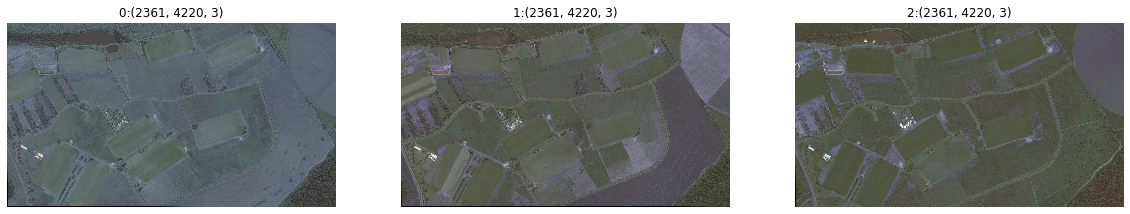

In [11]:
image = os.path.join(reference, 'reference.jpg')

# Open the image files. 
reference_image = cv2.imread(image, cv2.IMREAD_COLOR) # Reference image.
images_aligned = []

for img in os.listdir(originals):
    try:
        image_to_align = cv2.imread(os.path.join(originals, img), cv2.IMREAD_COLOR)

        height, width = reference_image.shape[0],reference_image.shape[1]
        dimensions = (width, height)

        image_to_align = cv2.resize(image_to_align, dimensions, interpolation = cv2.INTER_AREA)

        im1_gray = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
        im2_gray = cv2.cvtColor(image_to_align, cv2.COLOR_BGR2GRAY)
        
        # Find size of reference image
        size = reference_image.shape
        
        # Define the motion model
        warp_mode = cv2.MOTION_HOMOGRAPHY
        
        # Define 2x3 or 3x3 matrices and initialize the matrix to identity
        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            warp_matrix = np.eye(3, 3, dtype=np.float32)
        else :
            warp_matrix = np.eye(2, 3, dtype=np.float32)
        
        # Specify the number of iterations.
        number_of_iterations = 10;

        # Specify the threshold of the increment
        # in the correlation coefficient between two iterations
        termination_eps = 1e-10;
        
        # Define termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
        
        # Run the ECC algorithm. The results are stored in warp_matrix.
        (cc, warp_matrix) = cv2.findTransformECC(im1_gray, im2_gray, warp_matrix, warp_mode, criteria)

        if warp_mode == cv2.MOTION_HOMOGRAPHY:
            # Use warpPerspective for Homography
            im2_aligned = cv2.warpPerspective(image_to_align, warp_matrix, (size[1], size[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else :
            # Use warpAffine for Translation, Euclidean and Affine
            im2_aligned = cv2.warpAffine(image_to_align, warp_matrix, (size[1], size[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
        
        images_aligned.append(im2_aligned)

        # Show final results
        cv2.imwrite(aligned + img, im2_aligned)
        cv2.waitKey(0)
    except Exception as e:
        print(e)
        pass
    
plotAll(images_aligned)

Aplicação de contraste em cinza nas imagens para comparação e na imagem de referência
https://docs.opencv.org/master/d1/d5c/tutorial_py_kmeans_opencv.html

https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

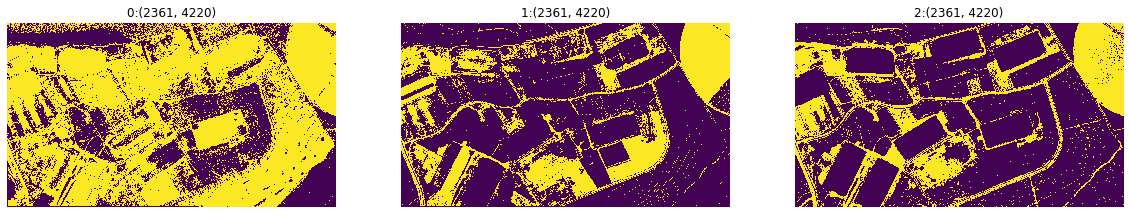

In [6]:
# Apply contrast on the reference image
image_to_contrast = os.path.join(reference, 'reference.jpg')
reference_image = cv2.imread(image_to_contrast, cv2.IMREAD_COLOR)

Z = reference_image.reshape((-1,3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2

ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)

res = center[label.flatten()]
res2 = res.reshape((reference_image.shape))

reference_gray_to_contrast = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)

p2 = np.percentile(reference_gray_to_contrast, 2)
p98 = np.percentile(reference_gray_to_contrast, 98)

reference_gray_to_contrast = exposure.rescale_intensity(reference_gray_to_contrast, in_range=(p2, p98))

cv2.waitKey(0)
cv2.imwrite(reference + 'reference_image_contrast.jpg', reference_gray_to_contrast)
cv2.destroyAllWindows()

images_contrast = []

# Apply contrast on the comparations images
for img in os.listdir(aligned):
    try:
        original_to_contrast = cv2.imread(os.path.join(aligned, img), cv2.IMREAD_COLOR)
       
        Z = original_to_contrast.reshape((-1,3))
        
        # convert to np.float32
        Z = np.float32(Z)

        # define criteria, number of clusters(K) and apply kmeans()
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 2
        ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        res = center[label.flatten()]
        res2 = res.reshape((original_to_contrast.shape))

        original_gray = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)

        #Increased contrast
        p2 = np.percentile(original_gray, 2)
        p98 = np.percentile(original_gray, 98)

        #Intensity correction
        original_gray = exposure.rescale_intensity(original_gray, in_range=(p2, p98))

        images_contrast.append(original_gray)

        cv2.waitKey(0)
        cv2.imwrite(grayscale + img, original_gray)
        cv2.destroyAllWindows()
    except Exception as e:
        print(e)
        pass

plotAll(images_contrast)

Encontrar pontos-chave nas imagens
https://www.sicara.ai/blog/2019-07-16-image-registration-deep-learning

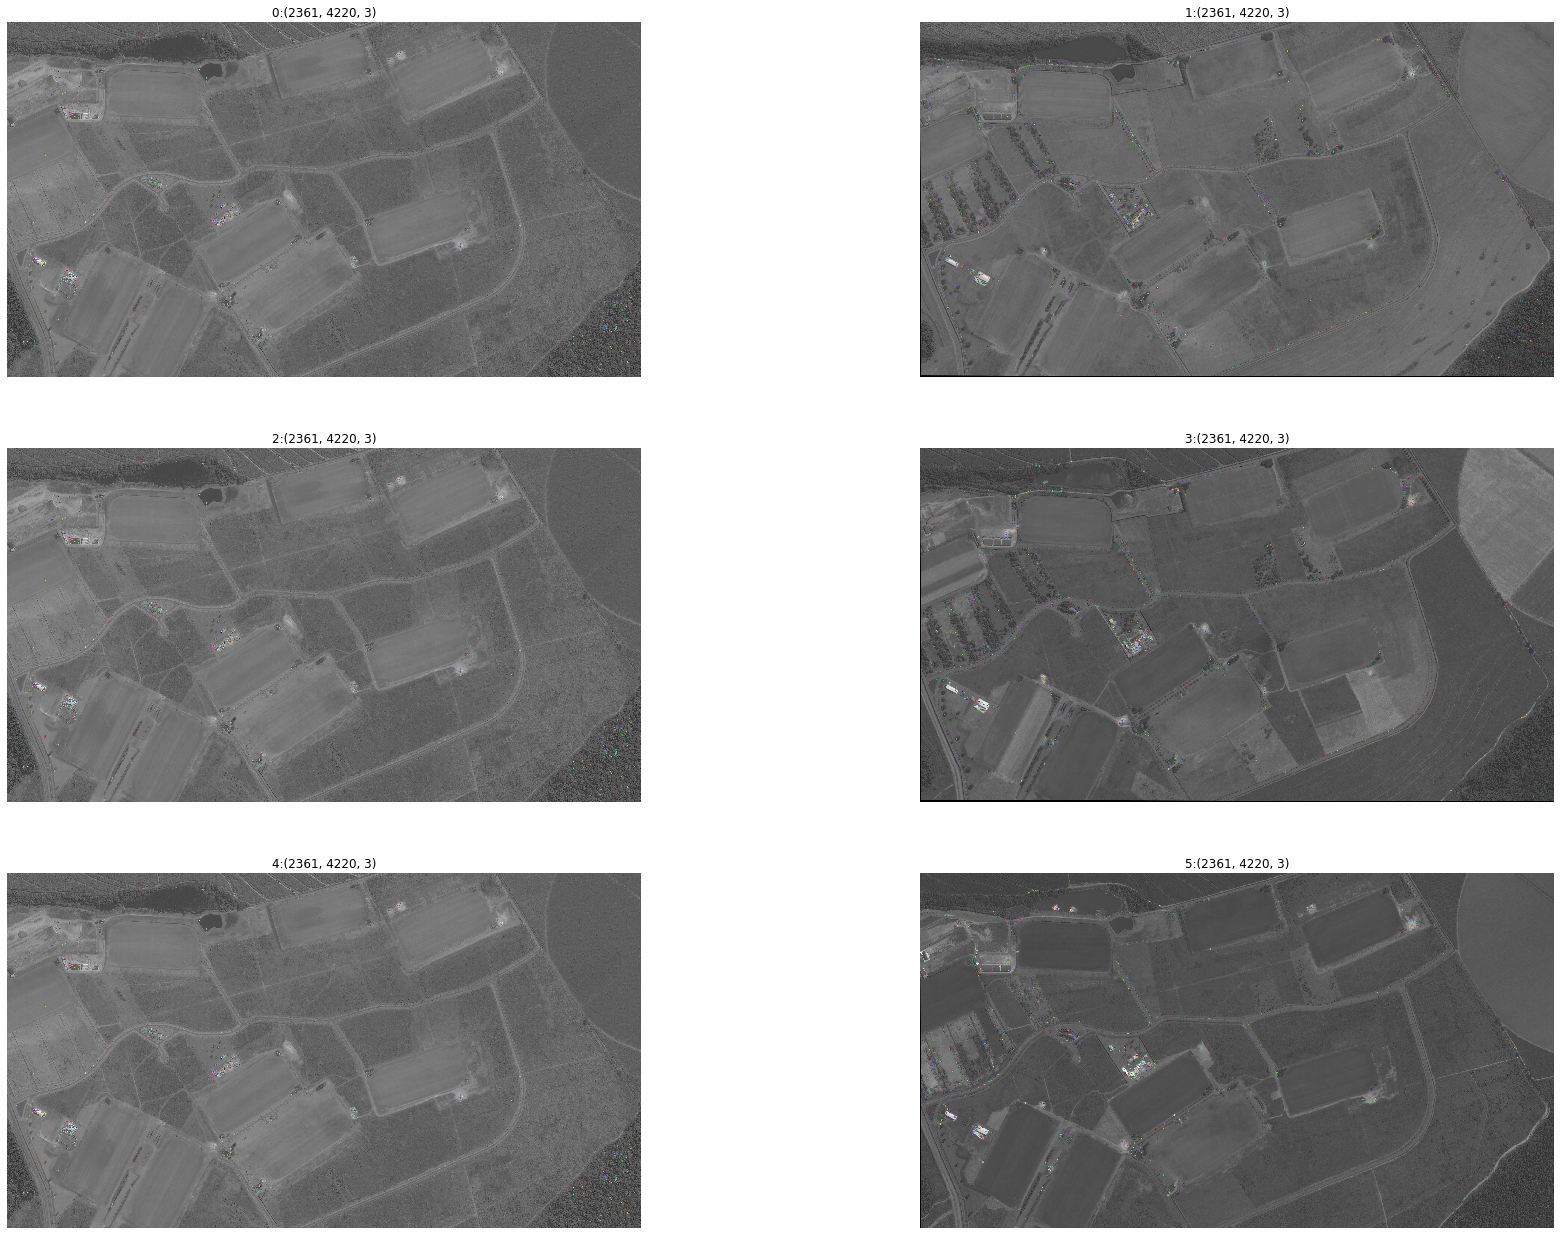

In [7]:
reference_image_path = os.path.join(reference, 'reference.jpg')

# Open the image files. 
reference_image = cv2.imread(reference_image_path, cv2.IMREAD_COLOR) # Reference image.
height, width = reference_image.shape[0], reference_image.shape[1]

image_keypoints = []

for img in os.listdir(aligned):
    try:
        original_image = cv2.imread(os.path.join(aligned, img), cv2.IMREAD_COLOR)

        gray1 = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

        # Initiate AKAZE detector
        akaze = cv2.AKAZE_create()

        # Find the keypoints and descriptors with SIFT
        kp1, des1 = akaze.detectAndCompute(gray1, None)
        kp2, des2 = akaze.detectAndCompute(gray2, None)

        img1_points = cv2.drawKeypoints(gray1, kp1, reference_image)
        img2_points = cv2.drawKeypoints(gray2, kp2, original_image)

        image_keypoints.append(img1_points)
        image_keypoints.append(img2_points)

        cv2.imwrite(keypoints + img, img1_points)
        cv2.imwrite(reference + 'keypoints_' + img, img2_points)
    except Exception as e:
        print(e)
        pass

plotAllTwoColumns(image_keypoints)

Calcular SSIM
https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

In [8]:
reference_image_path = os.path.join(reference, 'reference_image_contrast.jpg')

# Open the image files. 
reference_image_grayscale = cv2.imread(reference_image_path) # Reference image.
height, width = reference_image_grayscale.shape[0], reference_image_grayscale.shape[1]

for img in os.listdir(grayscale):
    try:
        # load the two input images
        original_image_grayscale = cv2.imread(os.path.join(grayscale, img))

        # convert the images to grayscale
        reference_gray = cv2.cvtColor(reference_image_grayscale, cv2.COLOR_BGR2GRAY)
        original_gray = cv2.cvtColor(original_image_grayscale, cv2.COLOR_BGR2GRAY)

        original_gray = cv2.resize(original_gray, (reference_gray.shape[1], reference_gray.shape[0]))

        # compute the Structural Similarity Index (SSIM) between the two
        # images, ensuring that the difference image is returned
        (score, diff) = compare_ssim(original_gray, reference_gray, full=True)
        diff = (diff * 255).astype("uint8")
        print("SSIM: {}".format(score))
        
    except Exception as e:
        print(e)
        pass

SSIM: 0.21799668061574085
SSIM: 0.14650920219747776
SSIM: 0.14173844549009704


Encontrar diferenças entre as imagens em cinza usando segmentação com subtração
https://stackoverflow.com/questions/56183201/detect-and-visualize-differences-between-two-images-with-opencv-python

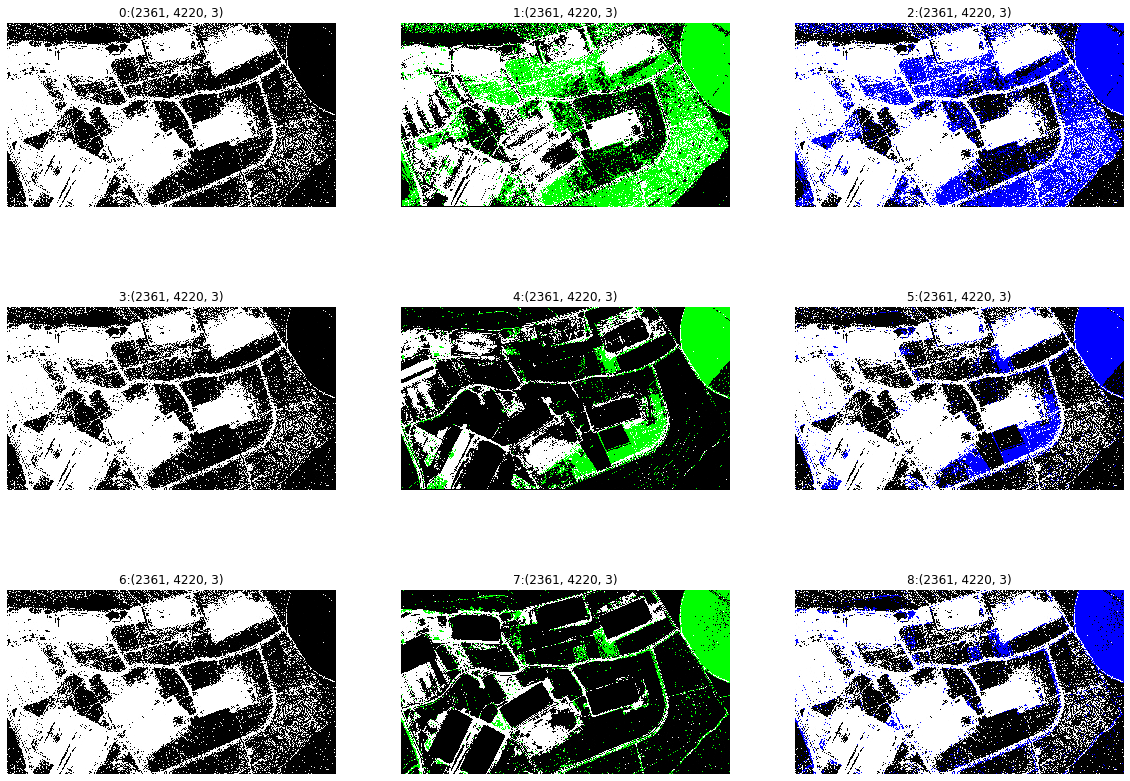

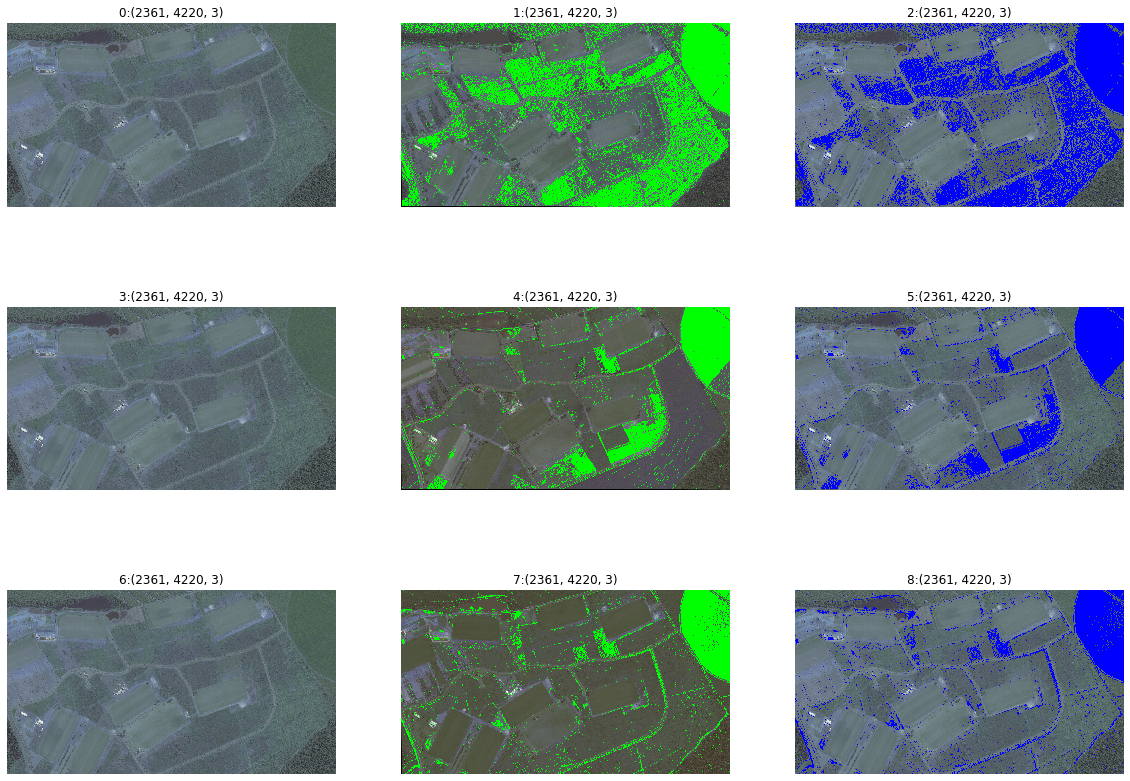

In [10]:
# Path reference image
image = os.path.join(reference, 'reference.jpg')

# Original image to compare with others
reference_image_original = cv2.imread(image, cv2.IMREAD_COLOR)

# Path contrast image
image_to_contrast = os.path.join(reference, 'reference_image_contrast.jpg')

# Image with contrast to compare with others
reference_image_contrast = cv2.imread(image_to_contrast)

differences_images_colour = []
differences_images_gray = []

for img in os.listdir(grayscale):
    # Image to apply mask
    reference_image = cv2.imread(image, cv2.IMREAD_COLOR)

    # Image with contrast to apply mask
    reference_image_grayscale = cv2.imread(image_to_contrast)

    try:

        # original
        original_image_grayscale = cv2.imread(os.path.join(grayscale, img))
        original_image_grayscale =  cv2.resize(original_image_grayscale, (reference_image_grayscale.shape[1], reference_image_grayscale.shape[0]))

        # # set size of image2 equal to image1
        original_image_colour = cv2.imread(os.path.join(aligned, img), cv2.IMREAD_COLOR)
        original_image_colour = cv2.resize(original_image_colour, (reference_image.shape[1], reference_image.shape[0]))

        # compute difference
        difference = cv2.subtract(original_image_grayscale, reference_image_grayscale)

        # color the mask red
        Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        
        difference[mask != 255] = [0, 0, 255]
        
        # add the red/green mask to the images to make the differences obvious
        reference_image_grayscale[mask != 255] = [0, 0, 255]
        original_image_grayscale[mask != 255] = [0, 255, 0]

        # add the red/green mask to the images to make the differences obvious
        reference_image[mask != 255] = [0, 0, 255]
        original_image_colour[mask != 255] = [0, 255, 0]

        differences_images_gray.append(reference_image_contrast)
        differences_images_gray.append(original_image_grayscale)
        differences_images_gray.append(reference_image_grayscale)

        differences_images_colour.append(reference_image_original)
        differences_images_colour.append(original_image_colour)
        differences_images_colour.append(reference_image)

        # store images
        cv2.imwrite(reference + 'masks_gray_' + img, reference_image_grayscale)
        cv2.imwrite(grayscale_masks + img, original_image_grayscale)

        cv2.imwrite(reference + 'masks_colour_' + img, reference_image)
        cv2.imwrite(colours_masks + img, original_image_colour)

        #cv2.imwrite(img, difference)

    except Exception as e:
        print(e)
        pass

plotAll(differences_images_gray)
plotAll(differences_images_colour)